In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm

from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math
import numpy as np

100%|██████████| 9912422/9912422 [00:00<00:00, 187282196.65it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111235715.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 166215424.84it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21501725.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



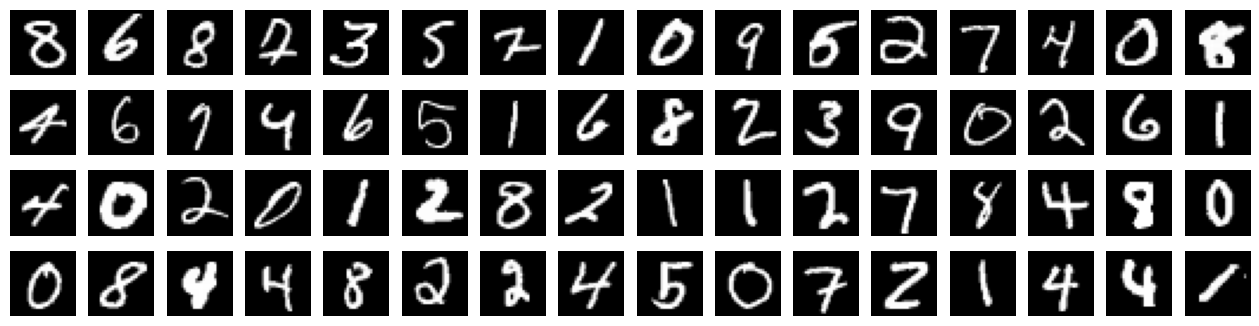

In [4]:

# Import the required libraries
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Extract a batch of unique images
unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()

# Display a grid of unique images
fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')  # Show the image using a grayscale colormap
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.show()  # Display the plot

In [5]:
# Forware diffusion for N steps IN 1d
def forward_diffusion_1D(x0, noise_strength_func, t0, nsteps, dt):
    """
    Parameters:
    - x0 :
    Returns:
    -x :
    """

    # Initiaize the trajectory array
    x = np.zeros(nsteps + 1)

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler time steps for diffusion simulation
    for i in range(nsteps):
        # Get noise
        noise_strength = noise_strength_func(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler method
        x[i+1] = x[i] + random_normal * noise_strength
        # print(x[i], end="--")

    # Return the trajecotyr and corresponing time points
    return x, t

In [6]:
# Example noise strength function
def noise_strength_constant(t):
    """
    """
    return 1

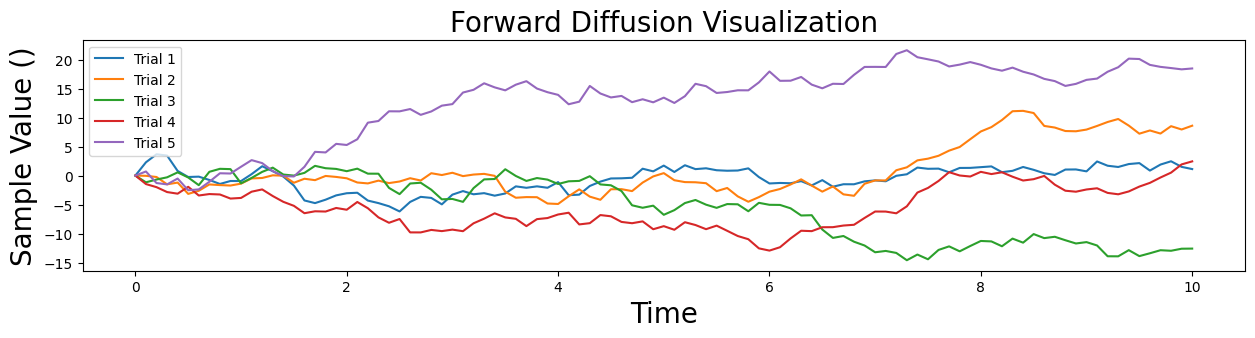

In [7]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ()', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()


In [8]:
# Reverse diffusin for N steps in 1D
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    """
    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set init sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    for i in range(nsteps):
        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])
        # Calcuate score uisng the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])
        # Generate a random normal variable
        random_normal = np.random.randn()
        # Update the trajectory using the reverse Euler method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    return x, t


In [9]:
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score


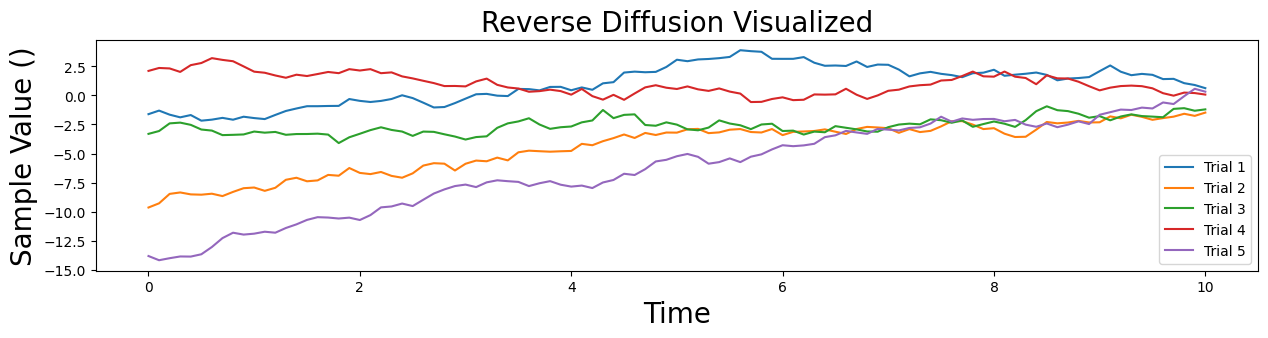

In [10]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot;+
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ()', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [11]:
# Define Gaussian random feature used to encode time steps
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.0) -> None:
        super().__init__()
        """
        Parameters:
        """
        # randomly sample weight (frequcne) during initialization
        # These weight are fixed
        #
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        """
        x_proj = x[:, None] * self.W[None, :] * 2 *np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=1)


In [12]:
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Apply fully connected layer then reshape to 4D tenosr
        return self.dense(x)[..., None, None]

In [13]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [14]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [15]:
# Marginal probabilyt Standard devaition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def marginal_prob_std(t, sigma):
    # convert time step to a Pytorch tensor
    t = torch.tensor(t).to(device)
    std = torch.sqrt((sigma**(2*t) - 1.0) / (2.0 * np.log(sigma)))
    return std

In [16]:
def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t).to(device)

In [17]:
# Initialize both marginal probability standard deviation and diffusion coefficient with sigma 25
sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [18]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    pertubed_x = x + z*std[:, None, None, None]

    # Get score from the model
    score = model(pertubed_x, random_t)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

In [19]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(1, 28, 28),
                            num_steps=num_steps,
                            device='cuda',
                            eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [20]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = MNIST('./data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-15-e2b07c3dee8f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-15-e2b07c3dee8f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-16-40f5d53a428b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t).to(device)


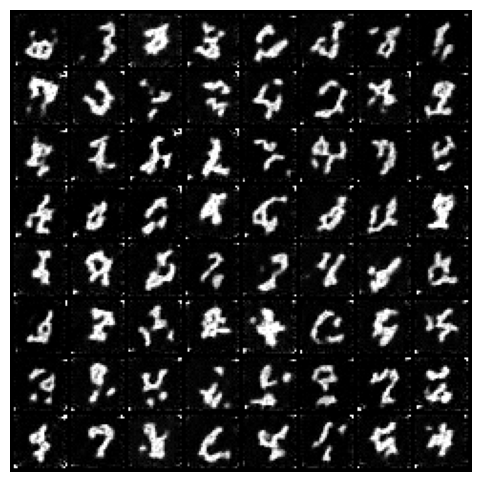

In [21]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [22]:

# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 75
batch_size = 1024
lr = 1e-3

# Load the MNIST dataset for training.
dataset = MNIST('./data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

<ipython-input-15-e2b07c3dee8f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)


0 Average Loss: 764.389538 lr 9.8e-04
1 Average Loss: 243.253366 lr 9.6e-04
2 Average Loss: 157.534031 lr 9.4e-04
3 Average Loss: 116.818022 lr 9.2e-04
4 Average Loss: 95.204382 lr 9.0e-04
5 Average Loss: 81.001507 lr 8.9e-04
6 Average Loss: 71.079493 lr 8.7e-04
7 Average Loss: 64.455065 lr 8.5e-04
8 Average Loss: 58.531860 lr 8.3e-04
9 Average Loss: 54.037050 lr 8.2e-04
10 Average Loss: 51.018147 lr 8.0e-04
11 Average Loss: 48.493884 lr 7.8e-04
12 Average Loss: 46.190919 lr 7.7e-04
13 Average Loss: 44.748839 lr 7.5e-04
14 Average Loss: 43.427392 lr 7.4e-04
15 Average Loss: 41.956461 lr 7.2e-04
16 Average Loss: 41.003555 lr 7.1e-04
17 Average Loss: 39.919733 lr 7.0e-04
18 Average Loss: 39.228043 lr 6.8e-04
19 Average Loss: 38.455112 lr 6.7e-04
20 Average Loss: 37.627327 lr 6.5e-04
21 Average Loss: 37.134065 lr 6.4e-04
22 Average Loss: 36.507180 lr 6.3e-04
23 Average Loss: 35.397058 lr 6.2e-04
24 Average Loss: 35.241928 lr 6.0e-04
25 Average Loss: 34.792746 lr 5.9e-04
26 Average Loss: 3

<ipython-input-15-e2b07c3dee8f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-16-40f5d53a428b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t).to(device)


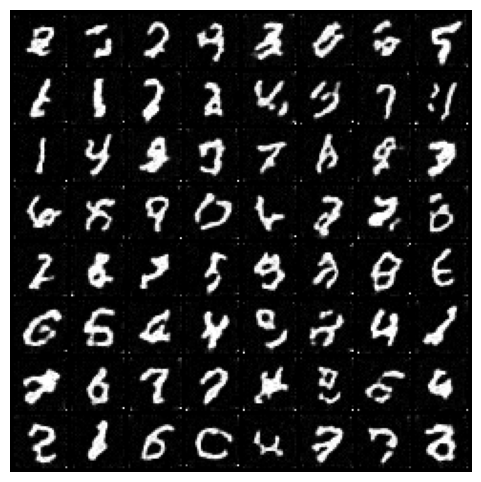

In [23]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt_res.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()